In [14]:
from pathlib import Path
from scipy.fftpack import fft, ifft
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

class ScopeWaveform:
    def __init__(self, inwfpn, infftpn=None):
        columns = ['info_name', 'value', 'units', 'time', 'waveform_value']
        self.inwfpn = inwfpn
        self.infftpn = infftpn

        # load waveform to dataframe
        self.df = pd.read_csv(inwfpn, names=columns)
        # load scope FFT to dataframe
        self.df_fft = None
        if infftpn:
            self.df_fft = pd.read_csv(infftpn, names=['info_name', 'value', 'units', 'frequency (Hz)', 'amplitude'])

        # add a partial sum column
        self.waveform_partial_integral()
    
    def peaks_freqiencies(self, amp, xs):
        '''
        Apply peak finding algorithms to identify peak values.
        '''
        peaks, props = find_peaks(amp, height=0.075)
        return [(xs[i], amp[i]) for i in peaks]

    def waveform_partial_integral(self):
        '''
        Partial sum of the waveform to study the pulse area.
        '''
        self.df['partial_integral'] = self.df.waveform_value.cumsum()
    
    def waveform_fft(self):
        '''
        Ref: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html
        '''
        X = fft(self.df.waveform_value.values)
        N = len(X)
        n = np.arange(N)
        # get the sampling rate
        sr = 1 / 2e-10
        T = N/sr
        freq = n/T

        # Get the one-sided specturm
        n_oneside = N//2
        # get the one side frequency
        f_oneside = freq[:n_oneside]

        # find the peaks in the frequency spectrum
        peak_coords = self.peaks_freqiencies(np.abs(X[:n_oneside]), f_oneside)

        # if no scope FFT file is provided, make two plots only
        if self.df_fft is None:
            # first, plot the original signal
            _, (ax1, ax2) = plt.subplots(2, figsize=(12,12))
            ax1.plot(self.df.time, self.df.waveform_value)
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel('amplitude (V)')

            ax2.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
            ax2.set_xlabel('Freq (Hz)')
            ax2.set_ylabel('FFT Amplitude |X(freq)|')
            for x, y in peak_coords:
                # ax2.annotate(f'{int(x*1e-6)} MHz', xy=(x, y))
                ax2.text(x, y+0.003, f'{int(x*1e-6)} MHz', rotation=90)
        else:
            plt.figure(figsize=(24,12))
            ax1 = plt.subplot(121)
            ax1.plot(self.df.time, self.df.waveform_value)
            ax1.set_xlabel('time (s)')
            ax1.set_ylabel('amplitude (V)')

            ax2 = plt.subplot(222)
            ax2.plot(f_oneside, np.abs(X[:n_oneside]), 'b')
            ax2.set_xlabel('Freq (Hz)')
            ax2.set_ylabel('FFT Amplitude |X(freq)|')
            for x, y in peak_coords:
                # ax2.annotate(f'{int(x*1e-6)} MHz', xy=(x, y))
                ax2.text(x, y+0.003, f'{int(x*1e-6)} MHz', rotation=90)
            ax2.set_title('FFT with scipy')
            
            ax3 = plt.subplot(224)
            ax3.plot(self.df_fft['frequency (Hz)'], self.df_fft.amplitude)
            ax3.set_xlabel('frequency (Hz)')
            ax3.set_ylabel('log(amplitude)')
            ax3.set_title('Spectral analysis from scope')

        # save to file
        out_dir = 'plots'
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        outfn = Path(self.inwfpn).stem
        outfpn = os.path.join(out_dir, outfn+'.png')
        
        plt.savefig(outfpn)
        plt.show()

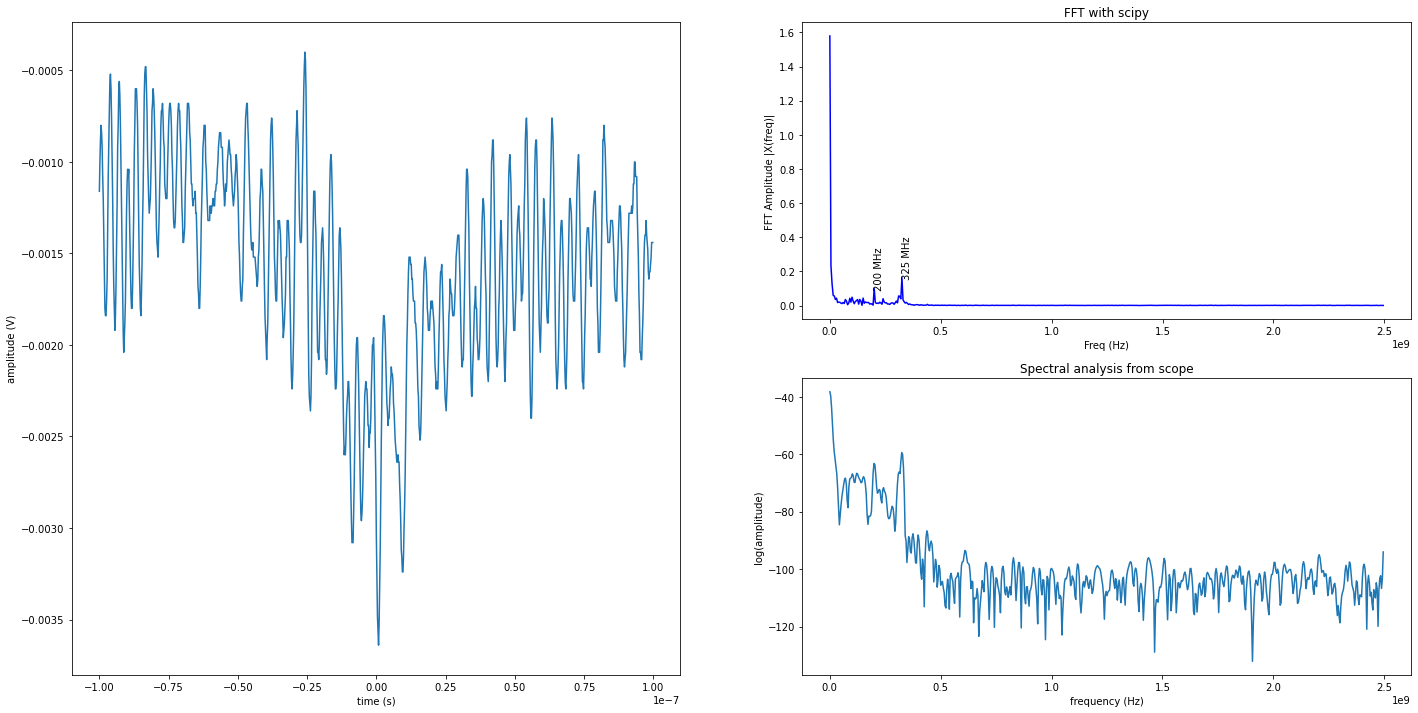

In [15]:
wf1 = ScopeWaveform('data/20220210_v925_all_output_terminated_waveform000.csv', 'data/20220210_v925_all_output_terminated_math1000.csv')
wf1.waveform_fft()